In [13]:
import csv
import pandas as pd
from lenskit import batch, topn
from lenskit import crossfold as xf
from lenskit.metrics import topn as tnmetrics
from lenskit.algorithms import Recommender
from lenskit.algorithms.user_knn import UserUser
from lenskit import topn
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsRegressor

In [14]:
preprocessed_dataset_folder = "../Data/PreprocessedDataset"
ratings_df = pd.read_csv(preprocessed_dataset_folder+"/ratings.csv")
movies_df = pd.read_csv(preprocessed_dataset_folder+"/movies.csv")
user_plots_ratings_df = pd.read_csv(preprocessed_dataset_folder+"/user_plots.csv") #first run notebook algorithm_experiments to get this data

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def getRecommendations(user_plots_ratings_df, user_id):
    print(user_plots_ratings_df['user_id'],"ids printed out")
    user_rated_movies = user_plots_ratings_df[user_plots_ratings_df['user_id'] == user_id]
    X = user_rated_movies['plot + title + genres']
    X_labels = user_rated_movies['item']
    y = user_rated_movies['rating']
    X_not_rated_labels = user_plots_ratings_df[user_plots_ratings_df['user_id'] != user_id]['item'].unique()
    X_not_rated = user_plots_ratings_df[user_plots_ratings_df['user_id'] != user_id]['plot + title + genres'].unique()
    vectorizer = TfidfVectorizer()
    print(X, "X printed out")
    X_tfidf = vectorizer.fit_transform(X)
    X_not_rated_tfidf = vectorizer.transform(X_not_rated)
    neigh = KNeighborsRegressor(n_neighbors=3, metric='cosine')
    neigh.fit(X_tfidf, y)
    y_pred = neigh.predict(X_not_rated_tfidf)
    not_rated_movies_predictions = pd.DataFrame({
        'item': user_plots_ratings_df[user_plots_ratings_df['user_id'] != user_id]['item'].unique(),
        'predicted_rating': y_pred
    })
    recommended_movies = pd.merge(not_rated_movies_predictions, movies_df, on='item')
    recommended_movies = recommended_movies.sort_values(by='predicted_rating', ascending=False).head(5)
    print(recommended_movies[['item', 'predicted_rating']])

    cosine_sim_matrix = cosine_similarity(X_not_rated_tfidf, X_tfidf)
    cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=X_not_rated_labels, columns=X_labels)
    return cosine_sim_df, recommended_movies


In [16]:
user_id = 66926

print(f"Recommendations for user {user_id}:")

cosine_sim_df,recommended_movies = getRecommendations(user_plots_ratings_df, user_id)
print("-----")
print(recommended_movies)

Recommendations for user 66926:
0         71683
1         71683
2         71683
3         71683
4         71683
          ...  
69737    126970
69738    126970
69739    126970
69740    126970
69741    126970
Name: user_id, Length: 69742, dtype: int64 ids printed out
49613    deathbed dashwood tells son first marriage joh...
49614    babe orphaned piglet chosen guess weight conte...
49615    suzanne stone dreams news anchor end marries l...
49616    fugitive bank robbers seth richie gecko hold d...
49617    major vic deakins john travolta captain riley ...
                               ...                        
49693    getting restraining order randal graves clerks...
49694    new headquarters behind famous hollywood sign ...
49695    graham hess mel gibson former reverend lives a...
49696    barry egan single man owns company markets the...
49697    scientist david banner idea create super soldi...
Name: plot + title + genres, Length: 85, dtype: object X printed out
     item  pred

In [17]:
def getExplanations(recommended_movies, cosine_sim_df,user_plots_ratings_df, user_id,k=3):
    explanations = []
    for index, row in recommended_movies.iterrows():
        recommended_item_id = row['item']
        item_title = row['title']
        string = f"Recommended item \"{item_title}\" because you previously watched items with similar plot:"
        explanations.append(string)
        print(string)
        cosine_sim_values = cosine_sim_df.loc[recommended_item_id].sort_values(ascending=False)
        
        similar_items = cosine_sim_values.index[0:k]
        
        similar_items_info = []
        for similar_item_id in similar_items:
            similar_item_title = movies_df[movies_df['item'] == similar_item_id]['title'].values[0]
            similar_item_rating = user_plots_ratings_df[(user_plots_ratings_df['item'] == similar_item_id) & (user_plots_ratings_df['user_id'] == user_id)]['rating'].values[0]
            similar_items_info.append((similar_item_id, similar_item_title, similar_item_rating))
        
        for i, (similar_item_id, similar_item_title, similar_item_rating) in enumerate(similar_items_info):
            string2 = f" {i+1})  \"{similar_item_title}\" (ID: {similar_item_id}) and gave rating: {similar_item_rating}"
            explanations.append(string2)
            print(string2)
    return explanations


In [18]:
expl = getExplanations(recommended_movies, cosine_sim_df,user_plots_ratings_df, user_id)

Recommended item " high noon" because you previously watched items with similar plot:
 1)  "citizen kane" (ID: 923) and gave rating: 5.0
 2)  "saving private ryan" (ID: 2028) and gave rating: 3.0
 3)  "blazing saddles" (ID: 3671) and gave rating: 4.5
Recommended item " citizen kane" because you previously watched items with similar plot:
 1)  "citizen kane" (ID: 923) and gave rating: 5.0
 2)  "bringing up baby" (ID: 955) and gave rating: 4.0
 3)  "big" (ID: 2797) and gave rating: 3.5
Recommended item " chocolat" because you previously watched items with similar plot:
 1)  "willy wonka & the chocolate factory" (ID: 1073) and gave rating: 4.0
 2)  "blazing saddles" (ID: 3671) and gave rating: 4.5
 3)  "happiness" (ID: 2318) and gave rating: 4.0
Recommended item " antz" because you previously watched items with similar plot:
 1)  "glory" (ID: 1242) and gave rating: 3.5
 2)  "blazing saddles" (ID: 3671) and gave rating: 4.5
 3)  "paths of glory" (ID: 1178) and gave rating: 4.0
Recommended 

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np

def preprocess_plot_text(plot_text):
    tokens = word_tokenize(plot_text.replace("|"," ")) # to split genres
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word.lower() for word in tokens if word.isalnum() and word.lower() not in stop_words]
    return " ".join(filtered_tokens)

movies_df['plot + title + genres'] = (movies_df['plot']+" "+movies_df['title']+" "+movies_df['genres']).apply(preprocess_plot_text)
def get_user_rated_movies_plots(new_user_df, movies):
    rated_item_ids = list(movies)
    rated_movies_df = movies_df[movies_df['item'].isin(rated_item_ids)]
    rated_movies_df = pd.merge(rated_movies_df[['item', 'plot + title + genres']], new_user_df, on='item')
    rated_movies_df['user_id'] = 0
    return rated_movies_df

In [ ]:
import tkinter as tk
from tkinter import messagebox

class MovieRatingGUI:
    def __init__(self, root, movies):
        self.root = root
        self.movies = movies
        self.ratings = {}
        self.create_movie_rating_form(submit_button_size=(20, 5), submit_button_position=(600, 300))

    def create_movie_rating_form(self, submit_button_size, submit_button_position):
        enlarged_width = 800 
        enlarged_height = 600 

        self.root.geometry(f"{enlarged_width}x{enlarged_height}")
        title_label = tk.Label(self.root, text="Pick at least 15 movies which you watched:", font=("Arial", 20))
        title_label.pack()
        scrollbar = tk.Scrollbar(self.root, orient=tk.VERTICAL)
        scrollbar.pack(side=tk.RIGHT, fill=tk.Y)
        self.movie_listbox = tk.Listbox(self.root, yscrollcommand=scrollbar.set, selectmode=tk.MULTIPLE, font=("Arial", 15), height=20, width=50)
        for movie in self.movies:
            self.movie_listbox.insert(tk.END, movie)
        self.movie_listbox.pack(side=tk.LEFT, padx=20, pady=20)
        scrollbar.config(command=self.movie_listbox.yview)
        submit_button = tk.Button(self.root, text="Submit", command=self.submit_ratings, width=submit_button_size[0], height=submit_button_size[1], bg="red")
        submit_button.place(x=submit_button_position[0], y=submit_button_position[1])

    def submit_ratings(self):
        selected_movies_indices = self.movie_listbox.curselection()
        if len(selected_movies_indices) < 15:
            messagebox.showerror("Error", "Please select at least 15 movies.")
        else:
            selected_movies = [self.movies[index] for index in selected_movies_indices]
            if len(selected_movies) > 15:
                selected_movies = selected_movies[:15]  
            self.show_selected_movies(selected_movies)

    def show_selected_movies(self, movies):
        new_window = tk.Tk()
        new_window.title("Rate Selected Movies")
        
        movie_ratings = {}

        for movie in movies:
            label = tk.Label(new_window, text=movie, font=("Arial", 10))
            label.grid(row=movies.index(movie), column=0, sticky="w", padx=10, pady=1)
            rating_scale = tk.Scale(new_window, from_=0, to=5, orient=tk.HORIZONTAL, resolution=0.1)
            rating_scale.grid(row=movies.index(movie), column=1, padx=10, pady=1)
            movie_ratings[movie] = rating_scale

        submit_button = tk.Button(new_window, text="Submit Ratings", command=lambda: self.submit_ratings_with_ratings(new_window, movie_ratings))
        submit_button.grid(row=len(movies), columnspan=2, pady=10)


    def submit_ratings_with_ratings(self, window, movie_ratings):
        new_user = [{'title': movie, 'rating': float(rating.get())} for movie, rating in movie_ratings.items()]
        new_user_df = pd.DataFrame(new_user)
        print("aaaaa")
        
        selected_titles = new_user_df['title'].tolist()
        filtered_movies_df = movies_df[movies_df['title'].isin(selected_titles)]
        new_user_df = pd.merge(new_user_df, filtered_movies_df[['item', 'title']], on='title')
        user_plot = get_user_rated_movies_plots(new_user_df, filtered_movies_df['item'])
        user_plot_all = pd.concat([user_plots_ratings_df, user_plot], axis=0)
        cosine, recomm = getRecommendations(user_plot_all, 0)
        explanations = getExplanations(recomm, cosine, user_plot_all, 0)
    
        explanation_window = tk.Tk()
        explanation_window.title("Rate explanations")
        window_width = 1000
        window_height = 800
        screen_width = explanation_window.winfo_screenwidth()
        screen_height = explanation_window.winfo_screenheight()

        x_coordinate = (screen_width - window_width) // 2
        y_coordinate = (screen_height - window_height) // 2
    
        explanation_window.geometry(f"{window_width}x{window_height}+{x_coordinate}+{y_coordinate}")
        explanations_listbox = tk.Listbox(explanation_window, font=("Arial", 12), width=80, height=20)
        explanations_listbox.grid(row=0, column=0, padx=20, pady=20)

        for explanation in explanations:
            explanations_listbox.insert(tk.END, explanation)

        questions = [
            "How much do these explanations help you make a decision on what to watch next?",
            "How much do these explanations increase trust in the system?",
            "How much do these explanations help you make decisions faster?"
        ]

        rating_scales = []
        current_row = 1  
        for question in questions:
            label = tk.Label(explanation_window, text=question, wraplength=800)
            label.grid(row=current_row, column=0, padx=20, pady=5, sticky=tk.W)
            current_row += 1

            scale = tk.Scale(explanation_window, from_=0, to=5, orient=tk.HORIZONTAL, resolution=0.1, length=200)
            scale.grid(row=current_row, column=0, padx=20, pady=5)
            current_row += 1

            rating_scales.append(scale)

        label_question = tk.Label(explanation_window, text="Is it better to have three similar items listed out or just one?", wraplength=800)
        label_question.grid(row=current_row, column=0, padx=20, pady=5, sticky=tk.W)
        current_row += 1
        class ToggleButton(tk.Button):
            def __init__(self, parent, **kwargs):
                self._values = ["1", "3"]
                self._current_index = 0
                super().__init__(parent, text=self._values[self._current_index], command=self.toggle, **kwargs)

            def toggle(self):
                self._current_index = 1 - self._current_index 
                self.config(text=self._values[self._current_index])

            def get_value(self):
                return self._values[self._current_index]

        toggle_button = ToggleButton(explanation_window, width=5)
        toggle_button.grid(row=current_row, column=0, padx=20, pady=5, sticky=tk.W)
        current_row += 1

        def submit_and_close():
            ratings = [scale.get() for scale in rating_scales]
            yes_no_answer = yes_no_answer = toggle_button.get_value()
            print(yes_no_answer)
            with open("../Data/PreprocessedDataset/feedback.csv", 'a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(ratings + [yes_no_answer])

        submit_button_2 = tk.Button(explanation_window, text="Submit Ratings", command=submit_and_close)
        submit_button_2.grid(row=current_row, column=0, pady=10)
            
movies_list =  movies_df['title'].values.tolist()

root = tk.Tk()
root.title("Movie Rating App")
app = MovieRatingGUI(root, movies_list)
root.mainloop()


Bellow we run experiments, 28 users paarticipated in the it. Informed consent was presented to them clarly. Survey consisted of 22 male and 6 female participants. Bellow you can see the distribution of ratings for each of three categories we tested: effectivness, trust, efficientcy. We also test how much information user wants from explanations.

In [15]:
feedback_df = pd.read_csv("../Data/PreprocessedDataset/feedback.csv")
print(feedback_df.head(5))

   Rating1  Rating2  Rating3  3/1
0      4.0      2.6      1.0    3
1      3.5      1.8      0.3    3
2      4.3      2.8      0.7    3
3      4.8      3.3      1.5    3
4      4.4      2.8      1.8    3


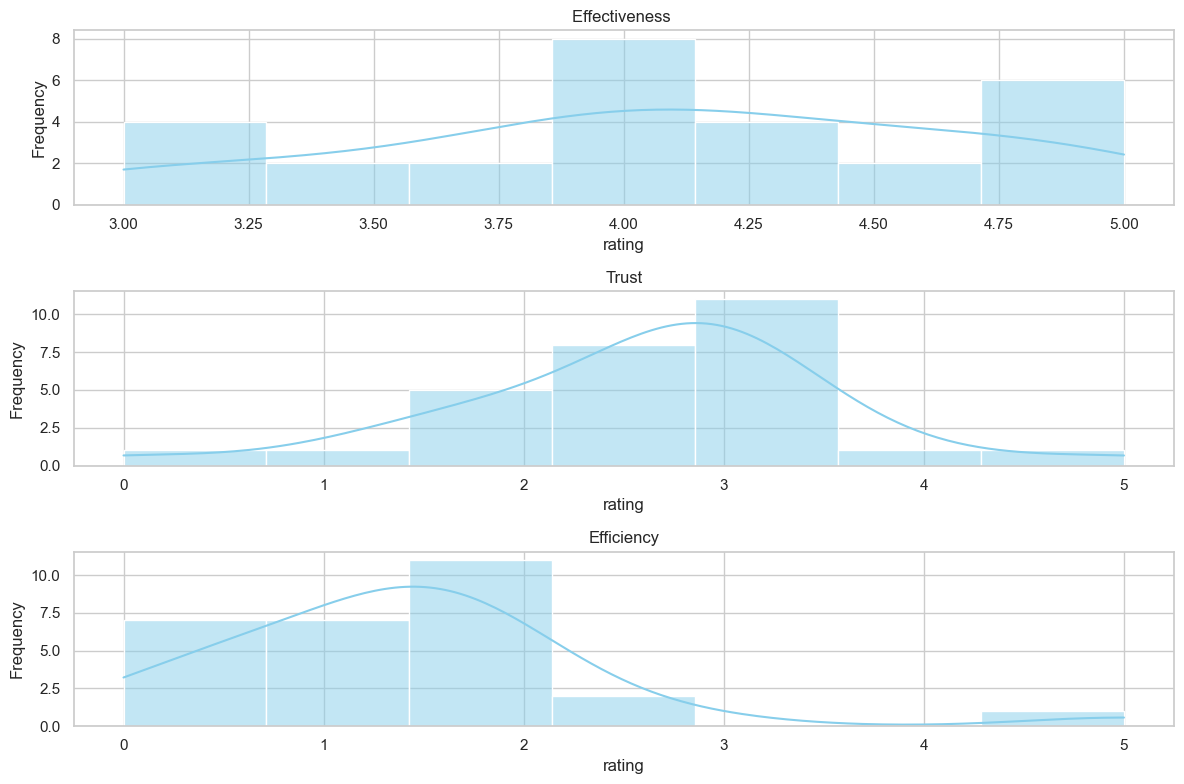

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.DataFrame(feedback_df)


sns.set(style="whitegrid")


plt.figure(figsize=(12, 8))
for i in range(1, 4):
    plt.subplot(3, 1, i)
    sns.histplot(df[f'Rating{i}'], kde=True, bins=7, color='skyblue')
    if i == 1:
        plt.title(f'Effectiveness ')
    if i == 2:
        plt.title(f'Trust')
    if i == 3:
        plt.title(f'Efficiency')
    plt.xlabel(f'rating')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [32]:
count = feedback_df['3/1'].value_counts()
print("This much users prefered just having listed one similar item to each recommended item: ",count[1])
print("This much users prefered having listed 3 similar items to each recommended item: ",count[3])
print("In total around",(int)(count[3]/(count[1]+count[3])*100),"% of users preffered having listed 3 similar items to each recommended item.")

print("Average rating for effectiveness: ",feedback_df['Rating1'].mean())
print("Average rating for trust: ",feedback_df['Rating2'].mean())
print("Average rating for efficiency: ",feedback_df['Rating3'].mean())

This much users prefered just having listed one similar item to each recommended item:  5
This much users prefered having listed 3 similar items to each recommended item:  23
In total around 82 % of users preffered having listed 3 similar items to each recommended item.
Average rating for effectiveness:  4.082142857142857
Average rating for trust:  2.614285714285714
Average rating for efficiency:  1.407142857142857
